<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

### Do not forget to put upvote for the notebook, follow me on Kaggle and the ⭐️ for github repo if you like it - one click for you, great pleasure for us ☺️ 
### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [964]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [965]:
%%capture
# !pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
# !pip install -U pandas

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [966]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

import seaborn as sns
import matplotlib.pyplot as plt

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [967]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900 # equal to 15 minutes
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [968]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [969]:
INPUT_DIR = 'data/'

In [970]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [971]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [972]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### Step 0.5. Some user feature preparation

Be creative :)

#### 0.5.1 Очистка данных

car_vin                   67.177143
vehicle_interior_color    19.194286
doors_cnt                  2.128571
vehicle_color              1.145714
vehicle_model              0.020000
vehicle_manufacturer       0.002857
vehicle_category           0.002857
vehicle_gearbox_type       0.002857
wheels                     0.002857
dtype: float64

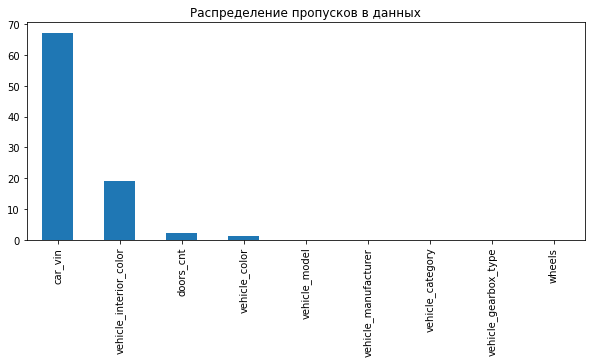

In [973]:
cols_null_percent = train_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

необходимо удалить столбец с вин-номером

In [974]:
def drop_columns(data, *args):
    """deleting columns from dataset

    Args:
        data (_type_): data - name of dataset
        *args - name of columns in dataset
        returns dataset
    """
    data = data.drop([*args], axis=1)
    return data

In [975]:
train_data = drop_columns(train_data, 'car_vin', 'row_ID')
test_data = drop_columns(test_data, 'car_vin', 'row_ID')

заполнение недостающих значений

In [976]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_manufacturer    34999 non-null  object 
 1   vehicle_model           34993 non-null  object 
 2   vehicle_category        34999 non-null  object 
 3   current_mileage         35000 non-null  int64  
 4   vehicle_year            35000 non-null  int64  
 5   vehicle_gearbox_type    34999 non-null  object 
 6   doors_cnt               34255 non-null  object 
 7   wheels                  34999 non-null  object 
 8   vehicle_color           34599 non-null  object 
 9   vehicle_interior_color  28282 non-null  object 
 10  car_leather_interior    35000 non-null  int64  
 11  deal_type               35000 non-null  object 
 12  final_price             35000 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 3.5+ MB


vehicle_interior_color    19.194286
doors_cnt                  2.128571
vehicle_color              1.145714
vehicle_model              0.020000
vehicle_manufacturer       0.002857
vehicle_category           0.002857
vehicle_gearbox_type       0.002857
wheels                     0.002857
dtype: float64

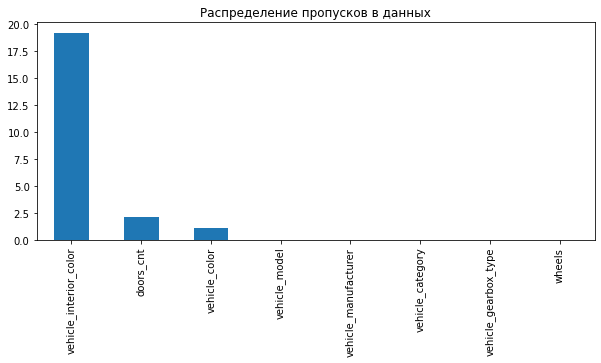

In [977]:
cols_null_percent = train_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

заполняем пропуски модами

In [978]:
# создаем копию исходной таблицы
fill_train_data = train_data.copy()
fill_test_data = test_data.copy()

In [979]:
# заменяем пропуски на моды
values = {
    'vehicle_interior_color': fill_train_data['vehicle_interior_color'].mode()[0],
    'doors_cnt': fill_train_data['doors_cnt'].mode()[0],
    'vehicle_color': fill_train_data['vehicle_color'].mode()[0],
    'vehicle_model': fill_train_data['vehicle_model'].mode()[0],
    'vehicle_manufacturer': fill_train_data['vehicle_manufacturer'].mode()[0],
    'vehicle_category': fill_train_data['vehicle_category'].mode()[0],
    'vehicle_gearbox_type': fill_train_data['vehicle_gearbox_type'].mode()[0],
    'wheels': fill_train_data['wheels'].mode()[0]
}

#в цикле пробегаемся по названиям столбцов с пропусками
# for col in cols_with_null.index:
#     #создаем новый признак-индикатор как col_was_null
#     fill_train_data[col + '_was_null'] = fill_train_data[col].isnull()
#     fill_test_data[col + '_was_null'] = fill_test_data[col].isnull()

fill_train_data = fill_train_data.fillna(values)
fill_test_data = fill_test_data.fillna(values)

In [980]:
train_data = fill_train_data
test_data = fill_test_data

на данном этапе пропусков в датасетах нет

#### 0.5.2 Работа с выбросами

Добавлю признак возраста авто на 2020 год и удалю год производства

In [981]:
def create_expert_feats(data):
    data['car_age'] = 2020 - data['vehicle_year']

create_expert_feats(train_data)
create_expert_feats(test_data)

# и удалим год
train_data = drop_columns(train_data, 'vehicle_year')
test_data = drop_columns(test_data, 'vehicle_year')

In [982]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_manufacturer    35000 non-null  object 
 1   vehicle_model           35000 non-null  object 
 2   vehicle_category        35000 non-null  object 
 3   current_mileage         35000 non-null  int64  
 4   vehicle_gearbox_type    35000 non-null  object 
 5   doors_cnt               35000 non-null  object 
 6   wheels                  35000 non-null  object 
 7   vehicle_color           35000 non-null  object 
 8   vehicle_interior_color  35000 non-null  object 
 9   car_leather_interior    35000 non-null  int64  
 10  deal_type               35000 non-null  object 
 11  final_price             35000 non-null  float64
 12  car_age                 35000 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 3.5+ MB


In [983]:
cleaned_train_data = train_data.copy()

In [984]:
# метод межквартильного размаха

def outliers_iqr(data, feature, lower_сoeff_iqr=1.5, upper_coef_iqr=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * lower_сoeff_iqr)
    upper_bound = quartile_3 + (iqr * upper_coef_iqr)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    print(f'По признаку {feature}:')
    print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
    print(f'Результирующее число записей: {cleaned.shape[0]}')
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    histplot = sns.histplot(data=cleaned, x=feature, ax=axes[0]);
    histplot.set_title(f'Cleaned {feature} Distribution');
    boxplot = sns.boxplot(data=cleaned, x=feature, ax=axes[1]);
    boxplot.set_title(f'Cleaned {feature} Boxplot');
    
    return outliers, cleaned


По признаку current_mileage:
Число выбросов по методу Тьюки: 365
Результирующее число записей: 34635


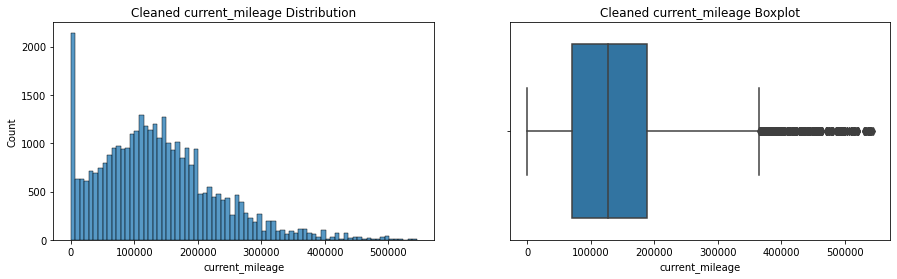

In [985]:
# для варианта с пробегом увеличиваем верхнюю границу с 1.5 до 3
outliers, cleaned = outliers_iqr(cleaned_train_data, 'current_mileage', 1.5, 3)
cleaned_train_data = cleaned

работа с годом выпуска

По признаку car_age:
Число выбросов по методу Тьюки: 45
Результирующее число записей: 34588


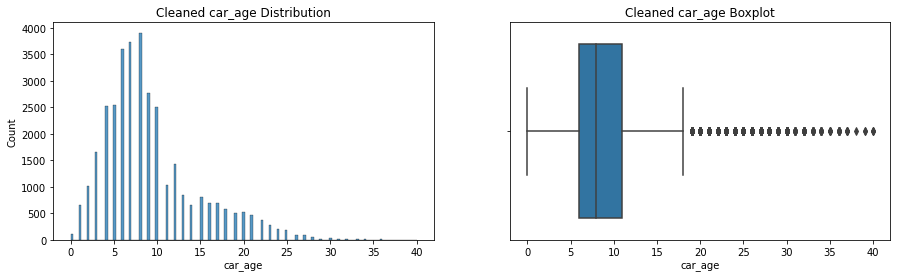

In [986]:
outliers, cleaned = outliers_iqr(cleaned_train_data, 'car_age', 1.5, 6)
# cleaned_train_data = cleaned

В данном случае, думаю нужно удалить только авто с возрастом больше 100 лет.

In [987]:
cleaned_train_data = cleaned_train_data[cleaned_train_data['car_age'] < 100]

работа с финальной ценой

Здесь удалим машины стоимостью более 200 000 и так же стоимостью меньше 1000.

По признаку final_price:
Число выбросов по методу Тьюки: 485
Результирующее число записей: 34149


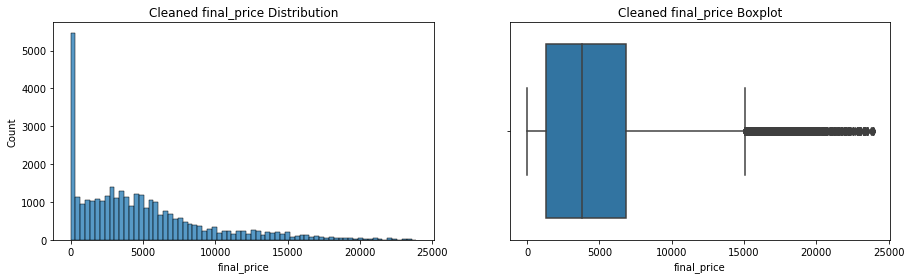

In [988]:
outliers, cleaned = outliers_iqr(cleaned_train_data, 'final_price', 3, 3)

In [989]:
# удаляем выбросы, определенные опытным путём
mask1 = cleaned_train_data['final_price'] < 200000
# нижний порог устанавливаем, чтобы не отбросить машины для аренды
mask2 = cleaned_train_data['final_price'] > 10
cleaned_train_data = cleaned_train_data[mask1 & mask2]

In [990]:
train_data = cleaned_train_data

#### 0.5.3 Проверка на дубликаты

In [991]:
# удаляем полностью дублирующие строки
train_data = train_data.drop_duplicates()

In [992]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26296 entries, 0 to 34999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_manufacturer    26296 non-null  object 
 1   vehicle_model           26296 non-null  object 
 2   vehicle_category        26296 non-null  object 
 3   current_mileage         26296 non-null  int64  
 4   vehicle_gearbox_type    26296 non-null  object 
 5   doors_cnt               26296 non-null  object 
 6   wheels                  26296 non-null  object 
 7   vehicle_color           26296 non-null  object 
 8   vehicle_interior_color  26296 non-null  object 
 9   car_leather_interior    26296 non-null  int64  
 10  deal_type               26296 non-null  object 
 11  final_price             26296 non-null  float64
 12  car_age                 26296 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 2.8+ MB


#### 0.5.4 Неинформативные признаки

In [993]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in train_data.columns:
    #наибольшая относительная частота в признаке
    top_freq = train_data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = train_data[col].nunique() / train_data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

deal_type: 98.15% одинаковых значений


In [994]:
train_data['deal_type'].unique()

array(['For Sale', 'For Rent'], dtype=object)

необходимо отдельно отбросить выбросы по цене для авто на продажу и на аренду

#### 0.5.5 Работа с выбросами_ver2

разбиваем датасет на 2 датасета. с авто на продажу и с авто на аренду

In [995]:
train_data_sale = train_data[train_data['deal_type'] == 'For Sale']
train_data_sale.shape

(25809, 13)

In [996]:
train_data_rent = train_data[train_data['deal_type'] == 'For Rent']
train_data_rent.shape

(487, 13)

По признаку final_price:
Число выбросов по методу Тьюки: 1597
Результирующее число записей: 24212


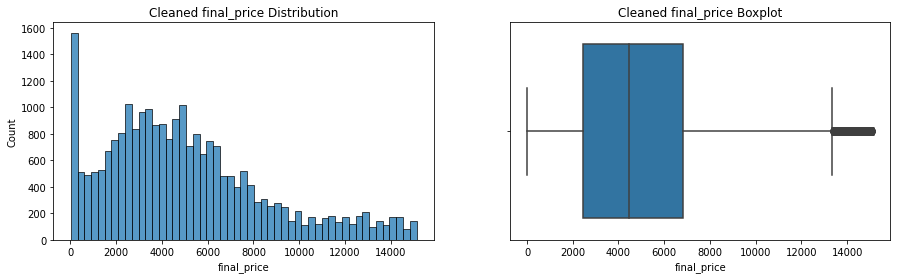

In [997]:
outliers, cleaned = outliers_iqr(train_data_sale, 'final_price')

По признаку final_price:
Число выбросов по методу Тьюки: 68
Результирующее число записей: 419


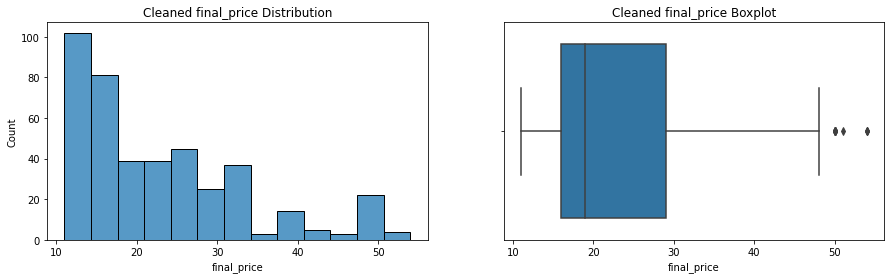

In [998]:
outliers, cleaned = outliers_iqr(train_data_rent, 'final_price')

Для авто на продажу мы уже отбросили неправдоподобно дорогие авто  
Остается отбросить слишком дешевые  
Для авто на аренду, отбрасываем слишком дорогие. Те что меньше 10, уже отброшены

In [999]:
mask1 = train_data_sale['final_price'] > 1500
train_data_sale = train_data_sale[mask1]

mask2 = train_data_rent['final_price'] < 500
train_data_rent = train_data_rent[mask2]

In [1000]:
train_data_sale.shape

(22026, 13)

In [1001]:
train_data_rent.shape

(465, 13)

Объединяем два датасета обратно в один

In [1002]:
train_data = pd.concat([train_data_sale, train_data_rent])

#### 0.5.6 Проектирование признаков

In [1003]:
%%time

def create_expert_feats(data):
# округляем пробег в большую сторону с шагом в 5000
    data['current_mileage'] = data['current_mileage'].apply(lambda x: 1000 * round(x/1000) if x > 500 else x)
# оставляем только основные цвета авто, остальные в other
    data['vehicle_color'] = data['vehicle_color'].apply(lambda x: x.strip() if x.strip() in ['Black', 'White', 'Silver', 'Grey', 'Blue'] else 'Other')
# то же самое с цветами интерьера
    data['vehicle_interior_color'] = data['vehicle_interior_color'].apply(lambda x: x.strip() if x.strip() in ['Black', 'White', 'Grey'] else 'Other')


create_expert_feats(train_data)
create_expert_feats(test_data)

CPU times: total: 31.2 ms
Wall time: 35.9 ms


#### 0.5.7 Кодирование признаков

In [1004]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22491 entries, 0 to 34986
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_manufacturer    22491 non-null  object 
 1   vehicle_model           22491 non-null  object 
 2   vehicle_category        22491 non-null  object 
 3   current_mileage         22491 non-null  int64  
 4   vehicle_gearbox_type    22491 non-null  object 
 5   doors_cnt               22491 non-null  object 
 6   wheels                  22491 non-null  object 
 7   vehicle_color           22491 non-null  object 
 8   vehicle_interior_color  22491 non-null  object 
 9   car_leather_interior    22491 non-null  int64  
 10  deal_type               22491 non-null  object 
 11  final_price             22491 non-null  float64
 12  car_age                 22491 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 2.4+ MB


In [1005]:
train_data['vehicle_manufacturer'].nunique()

66

In [1006]:
#цикл по всем столбцам
for col in train_data.columns:
    #уникальных
    unique_count = train_data[col].nunique()
    print(f'Feature: {col} --- uniques: {unique_count}')

Feature: vehicle_manufacturer --- uniques: 66
Feature: vehicle_model --- uniques: 2054
Feature: vehicle_category --- uniques: 11
Feature: current_mileage --- uniques: 506
Feature: vehicle_gearbox_type --- uniques: 4
Feature: doors_cnt --- uniques: 3
Feature: wheels --- uniques: 2
Feature: vehicle_color --- uniques: 6
Feature: vehicle_interior_color --- uniques: 4
Feature: car_leather_interior --- uniques: 2
Feature: deal_type --- uniques: 2
Feature: final_price --- uniques: 2800
Feature: car_age --- uniques: 57


In [1007]:
# one_hot_cols = ['vehicle_gearbox_type', 'vehicle_category', 'vehicle_gearbox_type',\
#     'doors_cnt', 'wheels', 'vehicle_color', 'vehicle_interior_color',\
#         'car_leather_interior', 'deal_type']

# train_data = pd.get_dummies(data=train_data, columns=one_hot_cols)
# test_data = pd.get_dummies(data=test_data, columns=one_hot_cols)

!!!!!!!!!!!!!!!!  
!!!!!!!!!!!!!!!!

двоичное кодирование признаков с большим количеством уникальных значений (??? как это синхронизируется с тестовой выборкой)

In [1008]:
# import category_encoders as ce # импорт для работы с кодировщиком
# bin_encoder = ce.BinaryEncoder(cols=['vehicle_manufacturer']) # указываем столбец для кодирования
# type_bin = bin_encoder.fit_transform(train_data['vehicle_manufacturer'])
# # clothing = pd.concat([clothing, type_bin], axis=1)

# type_bin

### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [1009]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (17992, 13), te_data = (4499, 13)


,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price,car_age
3653,HYUNDAI,Sonata,Sedan,58000,Automatic,4/5,Left wheel,Silver,Black,1,For Sale,9943.0,8
28421,TOYOTA,Aqua,Sedan,150000,Automatic,4/5,Right-hand drive,Silver,White,0,For Sale,4100.0,8
15779,FORD,C-MAX,Hatchback,105000,Automatic,4/5,Left wheel,White,White,1,For Sale,6400.0,7
32778,HYUNDAI,Elantra,Sedan,79000,Automatic,4/5,Left wheel,Grey,Black,1,For Sale,6097.0,7
21261,BMW,318,Hatchback,1000,Manual,2/3,Left wheel,Other,Black,0,For Sale,1600.0,23


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [1010]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [1011]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [1012]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [1013]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[21:30:43] Stdout logging level is INFO.
[21:30:43] Task: reg

[21:30:43] Start automl preset with listed constraints:
[21:30:43] - time: 900.00 seconds
[21:30:43] - CPU: 4 cores
[21:30:43] - memory: 16 GB

[21:30:43] Train data shape: (17992, 13)

[21:30:48] Layer 1 train process start. Time left 895.01 secs
[21:30:49] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[21:31:00] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2522.4841450063213
[21:31:00] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[21:31:00] Time left 883.80 secs



C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecat

[21:31:04] Selector_LightGBM fitting and predicting completed
[21:31:05] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecat

[21:31:29] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1816.4249463388592
[21:31:29] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[21:31:29] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 109.09 secs
[21:33:32] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[21:33:32] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[21:33:48] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1801.5438407703575
[21:33:48] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[21:33:48] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[21:34:16] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1889.5208147379635
[21:34:16] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[21:34:16] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
[21:39:16] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost c

In [1014]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.07618 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.69053 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.23329 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [1015]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[ 3940.842 ],
       [12067.305 ],
       [ 7723.9194],
       ...,
       [ 6838.497 ],
       [15128.211 ],
       [ 4967.342 ]], dtype=float32)
Shape = (4499, 1)
CPU times: total: 20.3 s
Wall time: 5.19 s


In [1016]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

TRAIN out-of-fold score: 1794.8211229948956
HOLDOUT score: 1670.953126375292


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

CPU times: total: 31.2 ms
Wall time: 36 ms


<AxesSubplot:xlabel='Feature'>

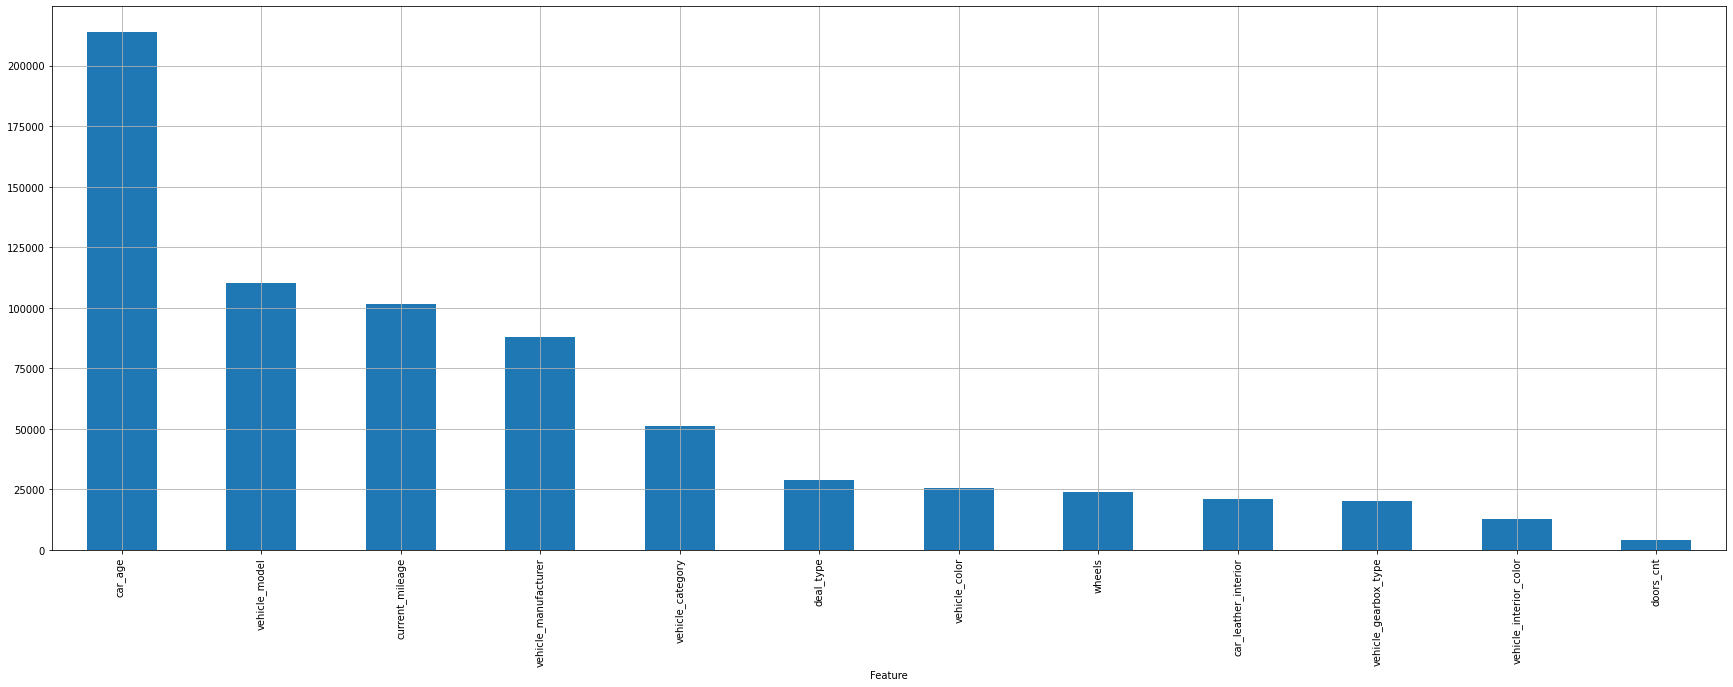

In [1017]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [1018]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

CPU times: total: 4min 31s
Wall time: 1min 9s


<AxesSubplot:xlabel='Feature'>

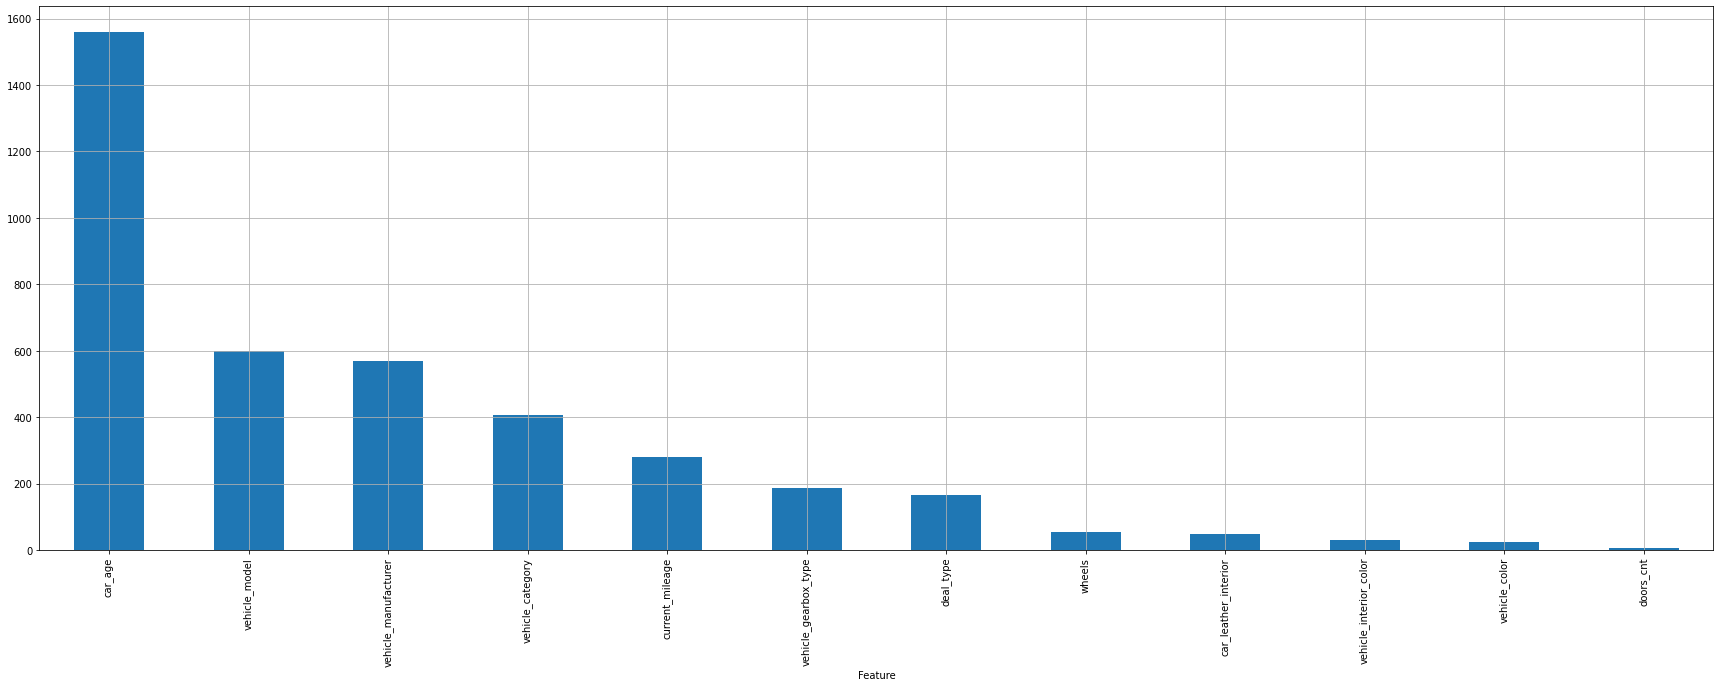

In [1019]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

In [1020]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 4194.329],
       [ 5967.958],
       [20613.873],
       ...,
       [17682.635],
       [ 5306.215],
       [ 6608.295]], dtype=float32)
Shape = (10697, 1)


In [1021]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('lightautoml_tabularautoml.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [1022]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

C:\Users\dolzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
